# Imports and Utils

In [152]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline

In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Load Data

In [47]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

# Depression Group Definitions

## Participant categories

- Severe symptoms (PHQ-9 ≥ 15)
- Moderate symptoms (PHQ-9 = 10-14)*
- Mild symptoms (PHQ-9 = 5-9)
- No symptoms (PHQ-9 < 5). 

We estimate that 30-50% of the PHQ-9 ≥ 15 group will show substantial drops of >5 points on the PHQ-9 during the study. Participants in the PHQ-9 = 5-14 range will show the maximum amount of movement in PHQ-9 scores over 4 months. We expect no substantive movement in depression among control participants with a PHQ-9 < 5.

In [48]:
group_df = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']

def categorize_phq(x):
    if x < 5: return "no_symp"
    if x <= 9: return "mild"
    if x <= 14: return "moderate"
    if x > 14: return "severe"
    return "N/A"

group_df['baseline_group'] = group_df['phq_total_sc'].apply(categorize_phq)


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [49]:
phq_group_dict = {k:v for k, v in zip(group_df['pid'].values, group_df['baseline_group'].values)}

phq_df['baseline_group'] = phq_df['pid'].map(phq_group_dict)

In [50]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

phq_df['study_wk'] = phq_df['redcap_event_name'].map(event_dict)

# Build Sequence DF

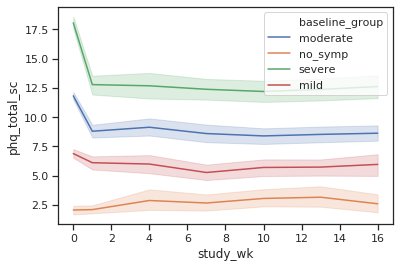

In [51]:
phq_df['phq_start'] = pd.to_datetime(phq_df['phq_start'])
sns.lineplot(x="study_wk", y="phq_total_sc", hue="baseline_group", data=phq_df)

In [52]:
survey_dates = [
    '2019-07-23',
    '2019-07-30',
    '2019-08-05', 
    '2019-08-20',
    '2019-08-26',
    '2019-09-10',
    '2019-09-16',
    '2019-10-01',
    '2019-10-07',
    '2019-10-21',
    '2019-10-29',
    '2019-11-11',
    '2019-11-19'
]

survey_idxs = []
phq_tots = []
phq_dates = []
baseline_groups = []
pids = []

for pid, group in phq_df.groupby('pid', as_index=False):

    
    for idx, date in enumerate(survey_dates):
        tot = np.nan
        phq_date = np.nan        
        sel_row = group[(group['phq_start'] > (pd.to_datetime(date) - pd.Timedelta(3, unit='D'))) & 
                        (group['phq_start'] < (pd.to_datetime(date) + pd.Timedelta(5, unit='D')))]
        #print(date)
        #display(sel_row)
        if sel_row.shape[0] > 0:
            tot = sel_row['phq_total_sc'].values[0]
            phq_date = sel_row['phq_start'].values[0]
            
        phq_tots.append(tot)
        phq_dates.append(phq_date)
        baseline_groups.append(group['baseline_group'].values[0])
        pids.append(pid)
        survey_idxs.append(idx)
        
phq_seq_df = pd.DataFrame()
phq_seq_df['pid'] = pids
phq_seq_df['baseline_group'] = baseline_groups
phq_seq_df['survey_idx'] = survey_idxs
phq_seq_df['date'] = phq_dates
phq_seq_df['phq_tot'] = phq_tots

phq_pivot = phq_seq_df.pivot_table(index="pid", columns=['survey_idx'])

# need better imputation, fill with mean for now
phq_pivot = phq_pivot.T.fillna(phq_pivot.mean(axis=1)).T

In [53]:
phq_seq_df.head()

,pid,baseline_group,survey_idx,date,phq_tot
0,00746649,moderate,0,2019-07-22 00:00:00,12.0
1,00746649,moderate,1,2019-07-30 12:31:50,13.0
2,00746649,moderate,2,2019-08-05 23:32:00,7.0
3,00746649,moderate,3,NaT,NaN
4,00746649,moderate,4,2019-08-26 19:04:10,9.0


In [54]:
phq_df.head(10)

,pid,phq01_sc,phq02_sc,phq03_sc,phq04_sc,phq05_sc,phq06_sc,phq07_sc,phq08_sc,phq_total_sc,phq10_sc,phq_start,redcap_event_name,baseline_group,study_wk
39,00746649,2,1,3,1,1,1,1,2,12,3,2019-07-22 00:00:00,week_0_arm_1,moderate,0
0,00746649,2,2,2,3,2,1,1,0,13,1,2019-07-30 12:31:50,week_1_arm_1,moderate,1
0,00746649,1,2,1,2,0,1,0,0,7,2,2019-08-05 23:32:00,week_1_arm_1,moderate,1
1,00746649,1,2,2,2,0,1,1,0,9,2,2019-08-26 19:04:10,week_4_arm_1,moderate,4
1,00746649,1,1,1,2,2,3,2,0,12,2,2019-09-10 14:28:31,week_7_arm_1,moderate,7
2,00746649,1,1,2,1,0,1,1,0,7,2,2019-09-16 19:08:22,week_7_arm_1,moderate,7
2,00746649,1,1,1,1,0,1,1,0,6,1,2019-10-01 10:53:03,week_10_arm_1,moderate,10
3,00746649,1,1,3,2,0,1,1,0,9,2,2019-10-07 21:55:19,week_10_arm_1,moderate,10
3,00746649,2,1,1,2,0,1,2,0,9,2,2019-10-22 13:02:22,week_13_arm_1,moderate,13
4,00746649,1,1,3,3,1,2,2,1,14,2,2019-10-28 19:03:53,week_13_arm_1,moderate,13


In [55]:
last_phq_df = phq_df.drop_duplicates(subset=['pid', 'redcap_event_name'], keep='last')

# State Changes

## Categorical definition of improvement: 

Standard clinical threshold is 5 point on PHQ-9 for full response, however, changes of 2 and 3 are often recommend for decision making. May not be important to categorize at first, given it’s not clear.

## Transition from depressed to non depressed.

Transition from depressed to non-depressed state will use the criterion for reliable and clinically significant change validated for the PHQ-9. Depressed participants (PHQ-9 ≥ 10) who subsequently show PHQ-9<10 and a reduction of ≥ 5 will be classified as transitioning from depressed to non-depressed. Similarly, non-depressed participants (PHQ-9 < 10) that subsequently have PHQ-9 ≥ 10 and an increase of ≥ 5 will be classified as having transitioned from nondepressed to depressed. 

## Depressed to non-depressed

- defined as a change from above 10 to below 10
- with a decrease of at least 5 points (and vice versa)

## Changes in Treatment

- txhx_start_fu: treatment history start date/time
- psytxhx_psychother_3wk: Have you seen a therapist, counselor or psychiatrist for depression, anxiety, or other emotional or mental health problems in the past 3 weeks?
- psytxhx_curr_meds_fu: Are you currently taking any medications to help you manage depression, anxiety, or other mental health problems?


- 162 participants began study reporting use of medication (120 without)
- 102 participants began study reporting recent visit to therapists (180 without)

In [56]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [85]:
last_phq_df = phq_df.drop_duplicates(subset=['pid', 'redcap_event_name'], keep='first')
last_phq_df['study_wk'] = last_phq_df['redcap_event_name'].map(event_dict)
all_state_df = state_df.merge(last_phq_df, on=['pid', 'study_wk', 'redcap_event_name'], how='left')

# replace 99s with nans, TODO better way to handle this?
all_state_df = all_state_df.replace(to_replace=99, value=np.nan)

all_state_df.head()

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pid,redcap_event_name,gad_start,gad01,gad02,gad03,gad04,gad05,gad06,gad07,...,phq03_sc,phq04_sc,phq05_sc,phq06_sc,phq07_sc,phq08_sc,phq_total_sc,phq10_sc,phq_start,baseline_group
0,00746649,week_0_arm_1,2019-07-22,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,3,1,1,1,1,2,12.0,3,2019-07-22 00:00:00,moderate
1,00746649,week_4_arm_1,2019-08-23 19:04:16,3.0,3.0,3.0,3.0,3.0,3.0,2.0,...,2,2,0,1,1,0,9.0,2,2019-08-26 19:04:10,moderate
2,00746649,week_7_arm_1,2019-09-14 15:19:45,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1,2,2,3,2,0,12.0,2,2019-09-10 14:28:31,moderate
3,00746649,week_10_arm_1,2019-10-04 16:25:27,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1,1,0,1,1,0,6.0,1,2019-10-01 10:53:03,moderate
4,00746649,week_13_arm_1,2019-10-25 22:38:25,3.0,2.0,2.0,2.0,2.0,3.0,3.0,...,1,2,0,1,2,0,9.0,2,2019-10-22 13:02:22,moderate


In [96]:
rm_corr_df = pd.DataFrame()
corr_df = pd.DataFrame()
psy_cols = ['psytxhx_psychother_3wk', 'psytxhx_curr_meds_fu']
for col in psy_cols:
    df = pg.rm_corr(data=all_state_df, x=col, y='phq_total_sc', subject='pid')
    df['feat'] = col
    rm_corr_df = rm_corr_df.append(df)
    
    df = pg.corr(x=all_state_df[col], y=all_state_df['phq_total_sc'], method='spearman')
    df['feat'] = col
    corr_df = corr_df.append(df)

In [97]:
rm_corr_df

,r,dof,pval,CI95%,power,feat
rm_corr,0.027,1149,0.356402,"[-0.03, 0.08]",0.152,psytxhx_psychother_3wk
rm_corr,0.103,1151,0.000457,"[0.05, 0.16]",0.939,psytxhx_curr_meds_fu


In [98]:
corr_df

,n,r,CI95%,r2,adj_r2,p-val,power,feat
spearman,1432,0.224,"[0.17, 0.27]",0.050,0.049,1.050179e-17,1.0,psytxhx_psychother_3wk
spearman,1434,0.235,"[0.19, 0.28]",0.055,0.054,1.618541e-19,1.0,psytxhx_curr_meds_fu


In [95]:
(all_state_df[psy_cols] == 99).sum()

psytxhx_psychother_3wk    0
psytxhx_curr_meds_fu      0
dtype: int64

In [91]:
all_state_df[psy_cols + ['phq_total_sc']].describe()

,psytxhx_psychother_3wk,psytxhx_curr_meds_fu,phq_total_sc
count,1584.000000,1587.000000,1435.000000
mean,0.332071,0.558286,8.522648
std,0.471105,0.496748,5.689797
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.000000
50%,0.000000,1.000000,8.000000
75%,1.000000,1.000000,12.000000
max,1.000000,1.000000,24.000000


### Pivot Table

In [99]:
state_pivot = all_state_df.pivot_table(index="pid", columns=['study_wk'])
state_pivot.head()
#state_pivot[state_pivot['psytxhx_curr_meds_fu'][0] == 1]['psytxhx_curr_meds_fu'].shape

gad01                          gad02                 ... spin_16  \
study_wk    0    4    7    10   13   16    0    4    7    10  ...      7    
pid                                                           ...           
00746649   1.0  3.0  2.0  3.0  3.0  1.0   1.0  3.0  2.0  3.0  ...     2.0   
01225297   3.0  1.0  2.0  2.0  1.0  2.0   3.0  1.0  2.0  2.0  ...     2.0   
01254121   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...     0.0   
01495950   1.0  1.0  2.0  1.0  2.0  2.0   0.0  0.0  1.0  1.0  ...     4.0   
01766910   2.0  2.0  2.0  2.0  1.0  1.0   2.0  1.0  1.0  2.0  ...     0.0   

                        spin_17                           
study_wk   10   13   16      0    4    7    10   13   16  
pid                                                       
00746649  4.0  3.0  3.0     4.0  4.0  3.0  4.0  4.0  4.0  
01225297  2.0  2.0  2.0     3.0  3.0  3.0  2.0  3.0  2.0  
01254121  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  
01495950  3.0  4.0  4.0     0.0  0.0  0.0  0.0  0.0  0.0  
01766910  0.0  0.0  1.0     3.0  1.0  2.0  2.0  1.0  2.0  

[5 rows x 365 columns]

AttributeError: 'AxesSubplot' object has no attribute 'label'

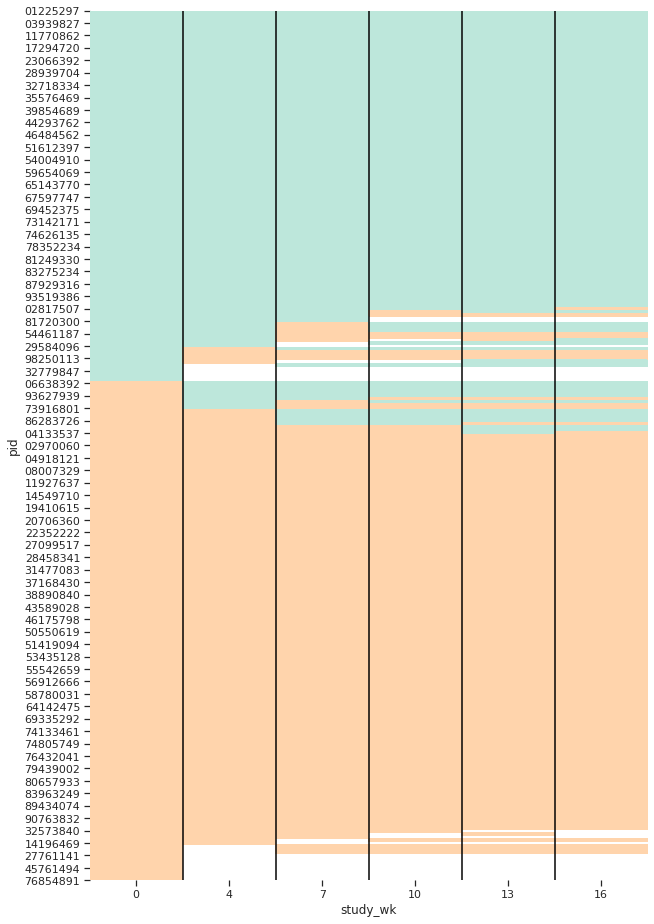

In [139]:
meds_pivot = state_pivot['psytxhx_curr_meds_fu']
meds_pivot = meds_pivot.sort_values(by=[0,4,7,10,13,16], ascending=True)
fig, ax = plt.subplots(figsize=(10,16))

for x in range(1,6):
    ax.axvline(x=x, color='black')
sns.heatmap(meds_pivot, 
            center=0.5,
            cbar=False,
            ax=ax)
            #square='true')
            #
            #linecolor='black',)
plt.title("Self-reported medication usage over time")

Text(0.5, 1, 'Self-reported therapy over time')

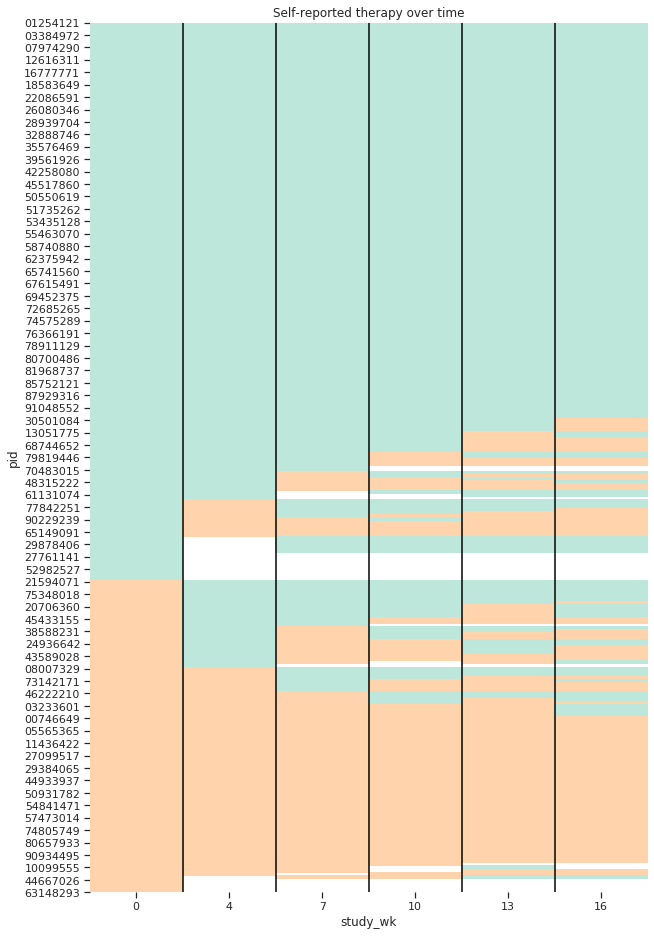

In [140]:
treat_pivot = state_pivot['psytxhx_psychother_3wk']
treat_pivot = treat_pivot.sort_values(by=[0,4,7,10,13,16], ascending=True)
fig, ax = plt.subplots(figsize=(10,16))

for x in range(1,6):
    ax.axvline(x=x, color='black')
sns.heatmap(treat_pivot, 
            center=0.5,
            cbar=False,
            ax=ax)
            #square='true')
            #
            #linecolor='black',)
plt.title("Self-reported therapy over time")

Text(0.5, 1, 'PHQ over time')

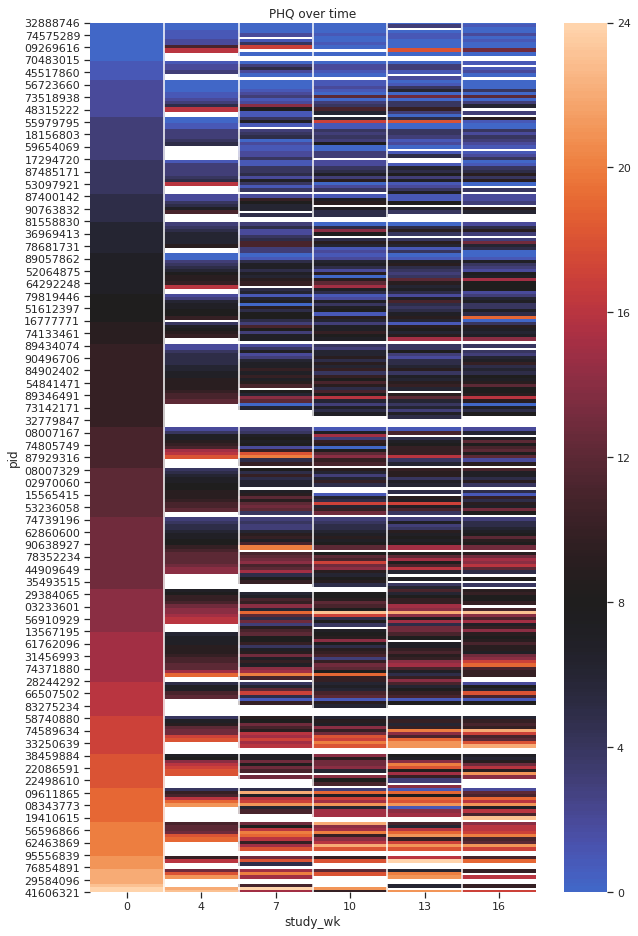

In [145]:
phq_pivot = state_pivot['phq_total_sc']
phq_pivot = phq_pivot.sort_values(by=[0,4,7,10,13,16], ascending=True)
fig, ax = plt.subplots(figsize=(10,16))

for x in range(1,6):
    ax.axvline(x=x, color='white')
sns.heatmap(phq_pivot, 
            center=8,
            cbar=True,
            ax=ax)
            #square='true')
            #
            #linecolor='black',)
plt.title("PHQ over time")

In [150]:
# phq_bin_pivot = (np.greater(phq_pivot, 10)).astype(int)
# phq_bin_pivot = phq_bin_pivot.sort_values(by=[0,4,7,10,13,16], ascending=True)
# fig, ax = plt.subplots(figsize=(10,16))

# for x in range(1,6):
#     ax.axvline(x=x, color='white')
# sns.heatmap(phq_bin_pivot, 
#             center=0.5,
#             cbar=True,
#             ax=ax)
#             #square='true')
#             #
#             #linecolor='black',)
# plt.title("PHQ over time")

# AR Models

## Autocorrelation analysis

In [ ]:
def build_autocorr(emm_df, target, n_lags=30):
    """Builds autocorr_dict and df for target EMA.
    
    
    Returns:
        dict, pd.DataFrame: autocorr_dict, autocorr_df
    """
    autocorr_dict = {}
    autocorr_matrix = np.zeros((len(pids), n_lags+1))
    for idx, pid in enumerate(pids):
        emm_pid = emm_df.loc[emm_df['pid'] == pid]
        n_lag = min(n_lags, emm_pid.shape[0])
        autocorr = []
        for i in range(n_lag+1):
            autocorr.append(emm_pid[target].autocorr(lag=i))

        autocorr_dict[pid] = autocorr
        autocorr_matrix[idx] = autocorr + [0] * (n_lags + 1 - len(autocorr))
        
    autocorr_df = pd.DataFrame(autocorr_matrix)
    autocorr_df['pid'] = pids
    autocorr_df = autocorr_df.merge(screener_df[['pid', 'group']], on='pid', how='left')
    autocorr_df = autocorr_df.set_index('pid')
    return autocorr_dict, autocorr_df


In [155]:
import statsmodels.tsa.ar_model as ar_model

ar_model = ar_model.AR.from_formula("phq_total_sc ~ psytxhx_psychother_3wk",data=all_state_df)

TypeError: __init__() got an unexpected keyword argument 'missing_idx'